In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
from matplotlib import image
import cv2
import pandas
import matplotlib.patches as patches
%matplotlib inline

In [2]:
ROOT_DIR = os.path.abspath("../../")

In [3]:
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

/Users/vramesh/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [7]:
class PedestrianConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "pedestrian"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = PedestrianConfig()
# config.display()

In [68]:
def dbscan(X, spatialeps, coloreps, pts_per_cluster):
    labels = np.ones((X.shape[0], X.shape[1])) * (-1)
    
    c_num = 0
    cluster_count = 0
    Q = []
    neighbor_lists = {}
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if labels[i,j] != -1:
                continue
            cluster, tmp_labels = build_cluster((i,j), X, np.copy(labels), neighbor_lists, c_num, coloreps, spatialeps)
            if len(cluster) >= pts_per_cluster:
                labels = tmp_labels
                c_num += 1
            else:
                neighbor_lists[(i,j)] = cluster
    return labels
            

def build_cluster(start, X, labels, neighbor_lists, C, color_eps, spatial_eps):
    Q = [start]
    cluster = {start}
    while Q:
        pt = Q.pop(0)
        if labels[pt[0], pt[1]] != -1:
            continue
        neighbors = get_neighbors(pt[0], pt[1], X.shape[0], X.shape[1], spatial_eps)
        cur_pt = X[pt[0], pt[1]]
        labels[pt[0], pt[1]] = C
        cluster.add(pt)
        for neighbor in neighbors:
            if np.linalg.norm(cur_pt - X[neighbor[0], neighbor[1]]) < color_eps:
                if neighbor in neighbor_lists:
                    labels[neighbor[0], neighbor[1]] = C
                    cluster.add(neighbor)
                    for n in neighbor_lists[neighbor]:
                        labels[n[0], n[1]] = C
                        cluster.add(n)
                else:
                    Q.append(neighbor)
    return cluster, labels
        

def get_neighbors(i,j, max_x, max_y, spatial_eps=1):
    i_bdry1 = int(max(i - spatial_eps, 0))
    i_bdry2 = int(min(i+spatial_eps+1, max_x))
    j_bdry1 = int(max(j - spatial_eps, 0))
    j_bdry2 = int(min(j+spatial_eps+1, max_y))
        
    neighbors = set([(x,y) for x in range(i_bdry1, i_bdry2) for y in range(j_bdry1, j_bdry2)])
    neighbors.remove((i,j))
    return list(neighbors)

def get_bounding_boxes(labels, top=10):
    unique, counts = np.unique(labels, return_counts=True)
    bbs = []
    a_sort = np.argsort(counts)
    best = unique[a_sort[-1*top:]]
    for i in best:
        if i == -1:
            continue
        pts = np.where(labels == i)
        bb = []
        bb.append((np.min(pts[0]), np.min(pts[1])))
        bb.append((np.min(pts[0]), np.max(pts[1])))
        bb.append((np.max(pts[0]), np.min(pts[1])))
        bb.append((np.max(pts[0]), np.max(pts[1])))
        bbs.append(bb)
    return bbs

def downsample_to_lab(img, num_times=2):
    n = 0
    labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    while(n<num_times):
        labimg = cv2.pyrDown(labimg)
        n = n+1
    return labimg

def view_dbscan(labels):
    unique, counts = np.unique(labels, return_counts=True)
    n_clusters_ = len(unique) - (1 if -1 in unique else 0)
    n_noise_ = counts[np.where(unique == -1)] if -1 in unique else 0
    # n_clusters_ = len(set(list(labels))) - (1 if -1 in labels else 0)
    # n_noise_ = np.count(labels,list(labels).count(-1)

    print("Number of clusters: ", n_clusters_)

    colors = [[int(plt.cm.Spectral(each)[0]*255),int(plt.cm.Spectral(each)[1]*255), int(plt.cm.Spectral(each)[2]*255)]
              for each in np.linspace(0, 1, n_clusters_)]


    out_img = np.zeros((labels.shape[0], labels.shape[1], 3))
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            if labels[i,j] == -1:
                color = [255, 255, 255]
            else:
                color = colors[int(labels[i,j])]
            out_img[i,j] = color
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(out_img)
    plt.show()

def view_bbs(lab_img, bbs):
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB))
    for bb in bbs:
        rect = patches.Rectangle((bb[0][1],bb[0][0]),abs(bb[2][1]-bb[1][1]),abs(bb[2][0]-bb[1][0]),linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()

Number of clusters:  300


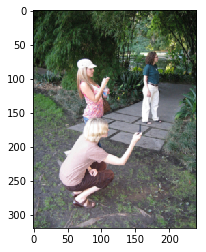

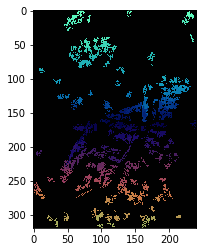

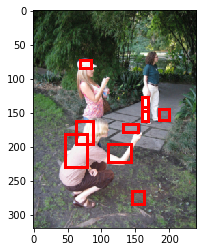

Number of clusters:  479


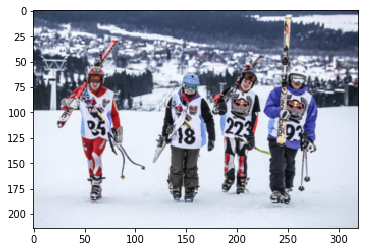

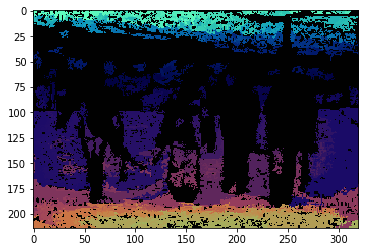

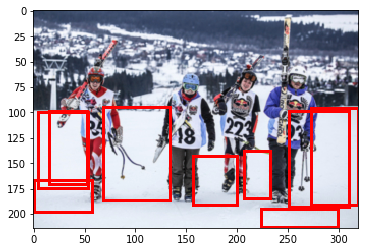

Number of clusters:  473


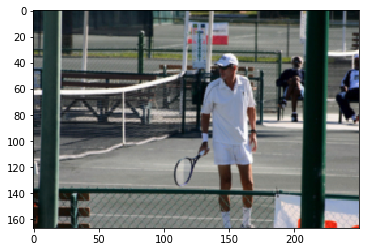

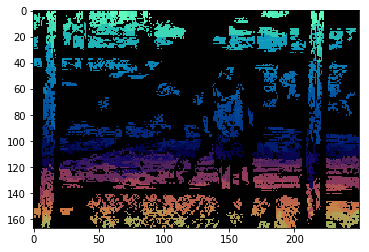

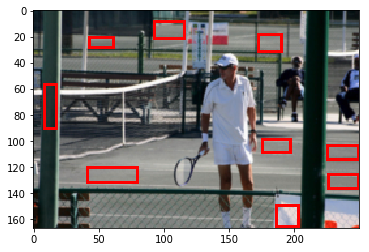

Number of clusters:  768


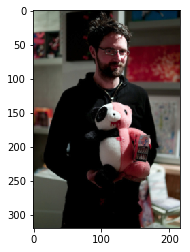

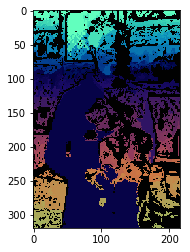

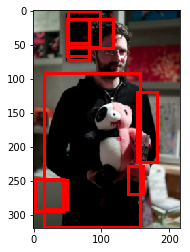

Number of clusters:  751


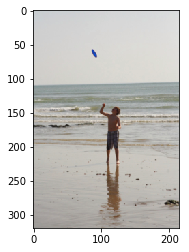

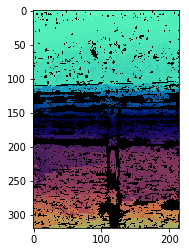

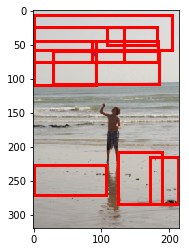

In [70]:
imgs = ['COCO_val2014_000000493751.jpeg', 
        'COCO_val2014_000000490051.jpeg',
        'COCO_val2014_000000492041.jpeg',
        'COCO_val2014_000000492465.jpeg',
        'COCO_val2014_000000496768.jpeg'
        ]
IMG_ROOT = '/Users/vramesh/Google Drive/University/Sem7/Computer Vision/final_project/Mask_RCNN/images/coco/'
for img_path_base in imgs:
    img_path = IMG_ROOT + img_path_base
    img = cv2.imread(img_path)
#     plt.figure()
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    lab_img = downsample_to_lab(img, 1)
#     plt.figure()
#     plt.imshow(cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB))

    labels = dbscan(lab_img, 2, 10, 30) # img, spatial eps, color eps, samples per cluster

    bbs = get_bounding_boxes(labels, top=10)

    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB))

    view_dbscan(labels)

    view_bbs(lab_img, bbs)

In [22]:
get_neighbors(0,0,10,10, 1)

[(0, 0), (0, 1), (1, 0), (1, 1)]

(333, 500, 3)
Is this even being called
(167, 250)
473
(167, 250, 3)
[255. 255. 255.]
[(18, 172), (18, 190), (31, 172), (31, 190)]
[(149, 186), (149, 203), (165, 186), (165, 203)]
[(56, 8), (56, 17), (90, 8), (90, 17)]
[(98, 175), (98, 197), (108, 175), (108, 197)]
[(20, 42), (20, 61), (28, 42), (28, 61)]
[(103, 225), (103, 249), (114, 225), (114, 249)]
[(125, 226), (125, 249), (136, 226), (136, 249)]
[(8, 92), (8, 115), (21, 92), (21, 115)]
[(120, 41), (120, 79), (131, 41), (131, 79)]


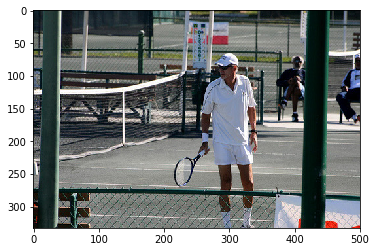

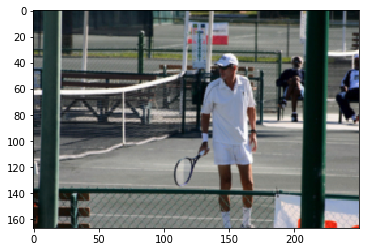

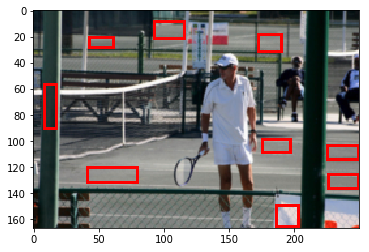

IndexError: index 300 is out of bounds for axis 0 with size 167

In [53]:


%matplotlib inline
# IMG_PATH = '/Users/vramesh/Google Drive/University/Sem7/Computer Vision/final_project/Mask_RCNN/images/coco/COCO_val2014_000000492465.jpeg'
IMG_PATH = '/Users/vramesh/Google Drive/University/Sem7/Computer Vision/final_project/Mask_RCNN/images/coco/COCO_val2014_000000492041.jpeg'
img = cv2.imread(IMG_PATH)
print(img.shape)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

n = 0
labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
while(n<1):
    labimg = cv2.pyrDown(labimg)
    n = n+1
plt.figure()
plt.imshow(cv2.cvtColor(labimg, cv2.COLOR_LAB2RGB))

# print(np.max(labimg))
# print(np.min(labimg))
# print(X.shape)

# db = DBSCAN(eps=1.5, min_samples=10).fit(X)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

labels = dbscan(labimg, 2, 10, 30)

print(labels.shape)
# # # Number of clusters in labels, ignoring noise if present.
unique, counts = np.unique(labels, return_counts=True)
n_clusters_ = len(unique) - (1 if -1 in unique else 0)
n_noise_ = counts[np.where(unique == -1)] if -1 in unique else 0
# n_clusters_ = len(set(list(labels))) - (1 if -1 in labels else 0)
# n_noise_ = np.count(labels,list(labels).count(-1)

print(n_clusters_)

colors = [[int(plt.cm.Spectral(each)[0]*255),int(plt.cm.Spectral(each)[1]*255), int(plt.cm.Spectral(each)[2]*255)]
          for each in np.linspace(0, 1, n_clusters_)]


out_img = np.zeros(labimg.shape)
for i in range(labimg.shape[0]):
    for j in range(labimg.shape[1]):
        if labels[i,j] == -1:
            color = [255, 255, 255]
        else:
            color = colors[int(labels[i,j])]
        out_img[i,j] = color

bbs = []
a_sort = np.argsort(counts)
best = unique[a_sort[-10:]]
for i in best:
    if i == -1:
        continue
    pts = np.where(labels == i)
    bb = []
    bb.append((np.min(pts[0]), np.min(pts[1])))
    bb.append((np.min(pts[0]), np.max(pts[1])))
    bb.append((np.max(pts[0]), np.min(pts[1])))
    bb.append((np.max(pts[0]), np.max(pts[1])))
    bbs.append(bb)
    
# for i in unique:
    
#     pts = np.where(labels == i)
    
#     new_lab = np.ones((out_img.shape[0], out_img.shape[1],4))
#     if i == -1:
#         out_img[pts] = [255,255,255]
#         continue
#     try:
#         tmp = np.mean(labimg[pts], axis=2)
#         print(tmp.shape)
#         print(new_lab.shape)
#         print(new_lab[pts[0],pts[1],0:3].shape)
        
        
#         new_lab[pts[0],pts[1],0:3] = tmp
#         out_img[pts] = cv2.cvtColor(new_lab, cv2.COLOR_LAB2RGB)
#     except:
#         tmp = labimg[pts]
        
#         print(tmp.shape)
#         print(new_lab.shape)
#         print(new_lab[pts[0],pts[1],0:3].shape)
#         new_lab[pts[0],pts[1],0:3] = tmp
        
#         out_img[pts,:] = cv2.cvtColor(new_lab[pts], cv2.COLOR_LAB2RGB)

print(out_img.shape)
print(out_img[0,1,:])
plt.figure()
fig, ax = plt.subplots(1)
# ax.imshow(out_img)
ax.imshow(cv2.cvtColor(labimg, cv2.COLOR_LAB2RGB))

import matplotlib.patches as patches
for bb in bbs:
    print(bb)
    rect = patches.Rectangle((bb[0][1],bb[0][0]),abs(bb[2][1]-bb[1][1]),abs(bb[2][0]-bb[1][0]),linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()


print(labels[300,100])
print(len(np.where(labels == labels[300,100])[0]))

In [45]:
# print(counts)
a_sort = np.argsort(counts)
print(unique[a_sort[-10:]])

[682. 172. 717.  53.  40. 716. 487.   2. 398.  -1.]


In [47]:
pts = np.where(labels == 398)
bb = []
bb.append((np.min(pts[0]), np.min(pts[1])))
bb.append((np.min(pts[0]), np.max(pts[1])))
bb.append((np.max(pts[0]), np.min(pts[1])))
bb.append((np.max(pts[0]), np.max(pts[1])))

print(bb)
print(len(pts[0]))

[(92, 16), (92, 156), (319, 16), (319, 156)]
15774


[(92, 16), (92, 156), (319, 16), (319, 156)]


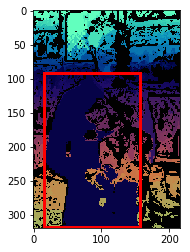

(16, 319)
140
227


In [50]:
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(out_img)
print(bb)
rect = patches.Rectangle((bb[0][1],bb[0][0]),abs(bb[2][1]-bb[1][1]),abs(bb[2][0]-bb[1][0]),linewidth=3,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

print((bb[2][1],bb[2][0]))
print(abs(bb[2][1]-bb[1][1]))
print(abs(bb[2][0]-bb[1][0]))
        